In [1]:
!pip install torch torchvision tqdm matplotlib numpy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import numpy as np



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
BATCH_SIZE = 32
IMAGE_SIZE = 64
z_dim = 128
image_channels=3
num_epochs = 800
learning_rate = 3e-4

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Path to the folder containing Pablo Picasso's images
path = '_data/art/Rembrandt'

# Create a dataset for only the Pablo Picasso folder
dataset = datasets.ImageFolder(path, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)


## Define Variational Autoencoder

In [25]:
class VAE(nn.Module):
    def __init__(self, image_channels=image_channels, z_dim=z_dim):
        super(VAE, self).__init__()

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8 -> 4
            nn.ReLU()
        )
        
        # Dynamically compute h_dim based on encoder output
        test_input = torch.zeros(1, image_channels, IMAGE_SIZE, IMAGE_SIZE)
        test_output = self.encoder(test_input)
        self.h_dim = test_output.view(-1).size(0)  # Flattened size after encoder

        # Latent space
        self.fc_mu = nn.Linear(self.h_dim, z_dim)
        self.fc_logvar = nn.Linear(self.h_dim, z_dim)

        # Decoder network
        self.decoder_fc = nn.Linear(z_dim, self.h_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),  # 32 -> 64
            nn.Tanh()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output of the encoder
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        # Ensure the reshaping matches [batch_size, 256, 4, 4]
        h = self.decoder_fc(z).view(-1, 256, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


# Instantiate the model and move it to the device
vae = VAE().to(device)

# Instantiate the model and move it to the device
vae = VAE().to(device)

## Define Loss Function

In [26]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (using MSE or Binary Cross Entropy)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss


## Train Variational Autoencoder

In [27]:
# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader)):
        data = data.to(device)
        
        # Forward pass through the VAE
        recon_batch, mu, logvar = vae(data)
        
        # Compute the loss
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch [1/800], Loss: 6788.1881


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [2/800], Loss: 5825.7688


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


Epoch [3/800], Loss: 3401.1618


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [4/800], Loss: 1991.2320


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [5/800], Loss: 1743.0024


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [6/800], Loss: 1548.4308


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [7/800], Loss: 1441.7387


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [8/800], Loss: 1354.6040


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [9/800], Loss: 1259.9789


100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


Epoch [10/800], Loss: 1148.9533


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [11/800], Loss: 1077.3487


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


Epoch [12/800], Loss: 1050.9616


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [13/800], Loss: 1038.0900


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [14/800], Loss: 1007.2426


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [15/800], Loss: 994.1437


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [16/800], Loss: 969.7051


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [17/800], Loss: 947.3328


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [18/800], Loss: 916.3738


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [19/800], Loss: 885.9752


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [20/800], Loss: 876.2644


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [21/800], Loss: 852.1605


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


Epoch [22/800], Loss: 849.4549


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [23/800], Loss: 832.6222


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [24/800], Loss: 823.3516


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [25/800], Loss: 811.2459


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [26/800], Loss: 803.5252


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [27/800], Loss: 796.7742


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [28/800], Loss: 789.3201


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [29/800], Loss: 780.9406


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [30/800], Loss: 779.2861


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [31/800], Loss: 776.8524


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [32/800], Loss: 763.1321


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [33/800], Loss: 748.9738


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [34/800], Loss: 731.9575


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [35/800], Loss: 729.0525


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [36/800], Loss: 715.6464


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [37/800], Loss: 707.5048


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [38/800], Loss: 691.2150


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [39/800], Loss: 678.0828


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [40/800], Loss: 675.3442


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [41/800], Loss: 657.2903


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [42/800], Loss: 646.9253


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [43/800], Loss: 638.8714


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [44/800], Loss: 641.8187


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [45/800], Loss: 616.6580


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


Epoch [46/800], Loss: 599.3194


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [47/800], Loss: 590.4120


100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


Epoch [48/800], Loss: 585.8643


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


Epoch [49/800], Loss: 587.5046


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [50/800], Loss: 576.8695


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [51/800], Loss: 565.9351


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [52/800], Loss: 553.5481


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [53/800], Loss: 551.7651


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [54/800], Loss: 548.0666


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [55/800], Loss: 543.3230


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [56/800], Loss: 538.3310


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


Epoch [57/800], Loss: 542.2495


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [58/800], Loss: 545.6779


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [59/800], Loss: 529.9515


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [60/800], Loss: 518.9322


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [61/800], Loss: 516.9977


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [62/800], Loss: 513.9201


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [63/800], Loss: 512.3876


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [64/800], Loss: 507.9243


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


Epoch [65/800], Loss: 504.7132


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


Epoch [66/800], Loss: 495.6618


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [67/800], Loss: 498.5333


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [68/800], Loss: 486.0337


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [69/800], Loss: 478.6060


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [70/800], Loss: 477.0589


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [71/800], Loss: 475.5339


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [72/800], Loss: 471.0825


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [73/800], Loss: 474.4158


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [74/800], Loss: 477.0846


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [75/800], Loss: 467.6464


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [76/800], Loss: 466.9006


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [77/800], Loss: 470.8746


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [78/800], Loss: 455.8169


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [79/800], Loss: 449.6735


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [80/800], Loss: 462.8406


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [81/800], Loss: 450.0750


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [82/800], Loss: 449.7566


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [83/800], Loss: 451.5270


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [84/800], Loss: 436.0457


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [85/800], Loss: 436.9869


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [86/800], Loss: 436.5013


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [87/800], Loss: 432.3336


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [88/800], Loss: 439.8766


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [89/800], Loss: 443.1543


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [90/800], Loss: 441.8050


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [91/800], Loss: 436.7667


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [92/800], Loss: 433.2306


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [93/800], Loss: 423.6547


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [94/800], Loss: 427.7097


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [95/800], Loss: 424.5865


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [96/800], Loss: 409.6781


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [97/800], Loss: 404.6876


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [98/800], Loss: 400.6790


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [99/800], Loss: 401.5263


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [100/800], Loss: 398.1025


100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


Epoch [101/800], Loss: 396.9339


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [102/800], Loss: 390.2043


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [103/800], Loss: 388.6192


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [104/800], Loss: 387.8669


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [105/800], Loss: 392.3904


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [106/800], Loss: 386.0025


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [107/800], Loss: 388.6221


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [108/800], Loss: 385.0237


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [109/800], Loss: 380.8339


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [110/800], Loss: 378.5174


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [111/800], Loss: 377.4302


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [112/800], Loss: 376.9509


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [113/800], Loss: 372.9015


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [114/800], Loss: 371.3434


100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


Epoch [115/800], Loss: 368.0822


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [116/800], Loss: 370.9998


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [117/800], Loss: 365.2759


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [118/800], Loss: 364.5794


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [119/800], Loss: 364.7517


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [120/800], Loss: 367.3659


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [121/800], Loss: 362.7796


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [122/800], Loss: 359.6164


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [123/800], Loss: 359.9516


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [124/800], Loss: 363.0305


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [125/800], Loss: 361.7729


100%|██████████| 9/9 [00:02<00:00,  3.80it/s]


Epoch [126/800], Loss: 358.8602


100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


Epoch [127/800], Loss: 352.8415


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


Epoch [128/800], Loss: 351.7647


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [129/800], Loss: 351.1099


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [130/800], Loss: 350.0684


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [131/800], Loss: 350.5314


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [132/800], Loss: 347.2738


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [133/800], Loss: 345.7051


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [134/800], Loss: 344.0791


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [135/800], Loss: 342.5992


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [136/800], Loss: 342.1190


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [137/800], Loss: 341.9814


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [138/800], Loss: 338.0428


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [139/800], Loss: 341.2312


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


Epoch [140/800], Loss: 335.7293


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [141/800], Loss: 335.5429


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [142/800], Loss: 333.2519


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [143/800], Loss: 335.7547


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [144/800], Loss: 340.3921


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [145/800], Loss: 335.5528


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [146/800], Loss: 340.5504


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [147/800], Loss: 338.1124


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [148/800], Loss: 332.1522


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [149/800], Loss: 333.7155


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [150/800], Loss: 326.8473


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [151/800], Loss: 327.0796


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [152/800], Loss: 330.8078


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [153/800], Loss: 330.4733


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


Epoch [154/800], Loss: 324.6804


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [155/800], Loss: 322.8421


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [156/800], Loss: 316.9152


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [157/800], Loss: 316.5335


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


Epoch [158/800], Loss: 318.4704


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [159/800], Loss: 316.6570


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [160/800], Loss: 316.4878


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [161/800], Loss: 312.5077


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [162/800], Loss: 313.3638


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [163/800], Loss: 312.5583


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [164/800], Loss: 310.9684


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [165/800], Loss: 312.8774


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [166/800], Loss: 311.1830


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [167/800], Loss: 309.1941


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [168/800], Loss: 312.7470


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [169/800], Loss: 310.6843


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [170/800], Loss: 306.7559


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


Epoch [171/800], Loss: 305.7493


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [172/800], Loss: 303.5963


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [173/800], Loss: 302.7007


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [174/800], Loss: 302.6337


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [175/800], Loss: 300.5189


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [176/800], Loss: 302.4021


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [177/800], Loss: 303.4698


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [178/800], Loss: 303.2183


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [179/800], Loss: 302.4084


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [180/800], Loss: 299.3040


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [181/800], Loss: 304.3982


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [182/800], Loss: 297.4172


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [183/800], Loss: 295.2765


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [184/800], Loss: 293.4557


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [185/800], Loss: 293.3985


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch [186/800], Loss: 293.4553


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [187/800], Loss: 297.3153


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


Epoch [188/800], Loss: 295.5319


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [189/800], Loss: 293.3063


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [190/800], Loss: 289.6957


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [191/800], Loss: 292.7514


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [192/800], Loss: 290.4308


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [193/800], Loss: 290.0824


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [194/800], Loss: 288.5940


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch [195/800], Loss: 289.0299


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch [196/800], Loss: 292.0178


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [197/800], Loss: 290.9298


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [198/800], Loss: 286.5063


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [199/800], Loss: 286.9117


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [200/800], Loss: 286.8455


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


Epoch [201/800], Loss: 283.2772


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [202/800], Loss: 283.4651


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [203/800], Loss: 282.7222


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [204/800], Loss: 282.9202


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [205/800], Loss: 283.5632


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [206/800], Loss: 281.5597


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [207/800], Loss: 284.5242


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [208/800], Loss: 282.2698


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [209/800], Loss: 276.8919


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [210/800], Loss: 275.4528


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [211/800], Loss: 277.1647


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [212/800], Loss: 279.3358


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [213/800], Loss: 281.0859


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [214/800], Loss: 277.7368


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


Epoch [215/800], Loss: 278.4587


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [216/800], Loss: 276.6162


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [217/800], Loss: 275.6711


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [218/800], Loss: 275.3519


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [219/800], Loss: 274.8246


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [220/800], Loss: 274.4404


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [221/800], Loss: 269.5179


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [222/800], Loss: 271.7958


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [223/800], Loss: 276.9150


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [224/800], Loss: 270.5103


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [225/800], Loss: 270.7034


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch [226/800], Loss: 271.4860


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [227/800], Loss: 269.8335


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [228/800], Loss: 268.8499


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [229/800], Loss: 268.0303


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [230/800], Loss: 267.5450


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [231/800], Loss: 267.0527


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [232/800], Loss: 266.7017


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [233/800], Loss: 268.9066


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [234/800], Loss: 270.6643


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [235/800], Loss: 268.3307


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [236/800], Loss: 264.6864


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [237/800], Loss: 265.6779


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [238/800], Loss: 266.9060


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [239/800], Loss: 265.6847


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [240/800], Loss: 265.7332


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [241/800], Loss: 265.0586


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [242/800], Loss: 264.8361


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [243/800], Loss: 264.1550


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [244/800], Loss: 262.2143


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [245/800], Loss: 266.6718


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [246/800], Loss: 258.0233


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [247/800], Loss: 257.6698


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [248/800], Loss: 261.5714


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [249/800], Loss: 258.6623


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [250/800], Loss: 255.2923


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [251/800], Loss: 259.2574


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [252/800], Loss: 258.8464


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [253/800], Loss: 255.9996


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [254/800], Loss: 254.2487


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [255/800], Loss: 257.6818


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [256/800], Loss: 255.3380


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [257/800], Loss: 254.9905


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [258/800], Loss: 252.5292


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [259/800], Loss: 255.0174


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [260/800], Loss: 254.6032


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [261/800], Loss: 251.6553


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [262/800], Loss: 251.1308


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [263/800], Loss: 253.4976


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [264/800], Loss: 254.8092


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [265/800], Loss: 253.5969


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [266/800], Loss: 250.2671


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [267/800], Loss: 251.2335


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [268/800], Loss: 251.3696


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [269/800], Loss: 249.9573


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [270/800], Loss: 250.9855


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [271/800], Loss: 247.7123


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [272/800], Loss: 248.3820


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [273/800], Loss: 250.2610


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [274/800], Loss: 246.6324


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [275/800], Loss: 245.4928


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [276/800], Loss: 248.0201


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [277/800], Loss: 245.9084


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [278/800], Loss: 245.1196


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


Epoch [279/800], Loss: 244.5572


100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


Epoch [280/800], Loss: 246.1641


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [281/800], Loss: 243.2279


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [282/800], Loss: 243.6933


100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


Epoch [283/800], Loss: 241.2795


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [284/800], Loss: 242.5563


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [285/800], Loss: 242.1897


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Epoch [286/800], Loss: 244.0047


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [287/800], Loss: 244.1560


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [288/800], Loss: 242.4316


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [289/800], Loss: 246.4004


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [290/800], Loss: 244.6243


100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


Epoch [291/800], Loss: 241.8226


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [292/800], Loss: 241.9184


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [293/800], Loss: 242.7593


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [294/800], Loss: 243.6392


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


Epoch [295/800], Loss: 242.8774


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [296/800], Loss: 241.3891


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [297/800], Loss: 244.4838


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [298/800], Loss: 241.9824


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [299/800], Loss: 238.8381


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [300/800], Loss: 237.5039


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [301/800], Loss: 235.8645


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [302/800], Loss: 235.4333


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [303/800], Loss: 236.2826


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [304/800], Loss: 237.2275


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [305/800], Loss: 234.5367


100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


Epoch [306/800], Loss: 234.5108


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [307/800], Loss: 235.2330


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [308/800], Loss: 233.5512


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [309/800], Loss: 232.7202


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [310/800], Loss: 233.1889


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [311/800], Loss: 233.2600


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [312/800], Loss: 233.2026


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [313/800], Loss: 231.4666


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [314/800], Loss: 232.3951


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [315/800], Loss: 234.0469


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [316/800], Loss: 232.0204


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [317/800], Loss: 233.6404


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [318/800], Loss: 240.0179


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [319/800], Loss: 241.7181


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [320/800], Loss: 233.0473


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [321/800], Loss: 233.4710


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [322/800], Loss: 231.3849


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [323/800], Loss: 229.2462


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [324/800], Loss: 228.9351


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [325/800], Loss: 228.8701


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [326/800], Loss: 229.0719


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [327/800], Loss: 226.6214


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [328/800], Loss: 232.6259


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [329/800], Loss: 234.2249


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [330/800], Loss: 230.0452


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [331/800], Loss: 228.8855


100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


Epoch [332/800], Loss: 232.6926


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [333/800], Loss: 229.3365


100%|██████████| 9/9 [00:02<00:00,  4.17it/s]


Epoch [334/800], Loss: 230.8166


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [335/800], Loss: 227.8253


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [336/800], Loss: 228.7234


100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


Epoch [337/800], Loss: 228.8081


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [338/800], Loss: 227.2940


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [339/800], Loss: 227.1897


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [340/800], Loss: 227.1212


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [341/800], Loss: 224.9160


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [342/800], Loss: 225.9298


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [343/800], Loss: 224.3952


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [344/800], Loss: 228.2493


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [345/800], Loss: 229.2468


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


Epoch [346/800], Loss: 226.5407


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


Epoch [347/800], Loss: 225.2176


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [348/800], Loss: 223.2974


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [349/800], Loss: 222.7256


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [350/800], Loss: 229.8279


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [351/800], Loss: 225.5749


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [352/800], Loss: 222.8405


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [353/800], Loss: 219.7274


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [354/800], Loss: 221.9426


100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


Epoch [355/800], Loss: 222.7354


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [356/800], Loss: 220.1168


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [357/800], Loss: 221.1950


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [358/800], Loss: 221.4880


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [359/800], Loss: 220.3887


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [360/800], Loss: 220.7537


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [361/800], Loss: 219.1166


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [362/800], Loss: 221.2878


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [363/800], Loss: 222.1579


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [364/800], Loss: 219.7773


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [365/800], Loss: 217.4338


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [366/800], Loss: 218.1265


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [367/800], Loss: 219.7680


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [368/800], Loss: 217.9296


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


Epoch [369/800], Loss: 217.6064


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch [370/800], Loss: 216.0959


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


Epoch [371/800], Loss: 218.8977


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [372/800], Loss: 219.3340


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


Epoch [373/800], Loss: 218.1631


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


Epoch [374/800], Loss: 219.0868


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [375/800], Loss: 216.6556


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch [376/800], Loss: 216.3959


100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


Epoch [377/800], Loss: 215.7738


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


Epoch [378/800], Loss: 218.9242


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [379/800], Loss: 216.6565


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [380/800], Loss: 215.5626


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [381/800], Loss: 217.5834


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [382/800], Loss: 217.1494


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [383/800], Loss: 213.9283


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Epoch [384/800], Loss: 216.0508


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [385/800], Loss: 214.2141


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [386/800], Loss: 217.4040


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [387/800], Loss: 215.8821


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [388/800], Loss: 217.7559


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [389/800], Loss: 215.0523


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [390/800], Loss: 213.8999


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [391/800], Loss: 212.9916


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch [392/800], Loss: 213.5434


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch [393/800], Loss: 212.2158


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [394/800], Loss: 210.5589


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [395/800], Loss: 210.7077


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [396/800], Loss: 210.8203


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch [397/800], Loss: 211.1719


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [398/800], Loss: 211.5336


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [399/800], Loss: 210.1596


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [400/800], Loss: 208.5414


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [401/800], Loss: 209.4011


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [402/800], Loss: 209.0320


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Epoch [403/800], Loss: 211.0830


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [404/800], Loss: 209.6487


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [405/800], Loss: 210.0349


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [406/800], Loss: 206.3139


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [407/800], Loss: 208.5258


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [408/800], Loss: 207.1794


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [409/800], Loss: 208.7253


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [410/800], Loss: 208.3773


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [411/800], Loss: 210.3748


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [412/800], Loss: 208.6277


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [413/800], Loss: 208.0524


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [414/800], Loss: 205.8096


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [415/800], Loss: 207.3636


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [416/800], Loss: 208.1110


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [417/800], Loss: 209.3118


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [418/800], Loss: 211.7286


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Epoch [419/800], Loss: 208.6902


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Epoch [420/800], Loss: 216.1057


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [421/800], Loss: 207.9806


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [422/800], Loss: 211.6101


100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


Epoch [423/800], Loss: 209.2046


100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


Epoch [424/800], Loss: 214.7062


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [425/800], Loss: 206.9357


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [426/800], Loss: 210.4201


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [427/800], Loss: 209.4097


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [428/800], Loss: 206.1935


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [429/800], Loss: 203.8476


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [430/800], Loss: 204.7000


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [431/800], Loss: 203.7196


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [432/800], Loss: 203.7203


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [433/800], Loss: 204.7614


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [434/800], Loss: 202.9870


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [435/800], Loss: 203.5420


100%|██████████| 9/9 [00:02<00:00,  4.17it/s]


Epoch [436/800], Loss: 201.7605


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


Epoch [437/800], Loss: 201.9289


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [438/800], Loss: 205.9163


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [439/800], Loss: 205.2701


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [440/800], Loss: 204.3455


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [441/800], Loss: 202.7727


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [442/800], Loss: 201.8421


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [443/800], Loss: 202.7779


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [444/800], Loss: 201.3741


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [445/800], Loss: 200.4646


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [446/800], Loss: 200.0870


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [447/800], Loss: 204.3212


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [448/800], Loss: 206.4769


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch [449/800], Loss: 202.0297


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


Epoch [450/800], Loss: 204.4550


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [451/800], Loss: 200.7076


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [452/800], Loss: 199.2247


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [453/800], Loss: 199.3056


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


Epoch [454/800], Loss: 198.2563


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [455/800], Loss: 199.3481


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


Epoch [456/800], Loss: 199.2825


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [457/800], Loss: 198.7827


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [458/800], Loss: 198.7421


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [459/800], Loss: 196.4288


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [460/800], Loss: 201.1998


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [461/800], Loss: 200.1372


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [462/800], Loss: 200.5894


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [463/800], Loss: 198.9059


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [464/800], Loss: 197.3613


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [465/800], Loss: 199.7739


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [466/800], Loss: 198.9640


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [467/800], Loss: 201.1515


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Epoch [468/800], Loss: 201.6357


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [469/800], Loss: 198.1791


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [470/800], Loss: 195.8792


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [471/800], Loss: 197.1924


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [472/800], Loss: 196.7572


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [473/800], Loss: 198.0690


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [474/800], Loss: 194.9053


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [475/800], Loss: 193.8441


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [476/800], Loss: 195.4423


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [477/800], Loss: 196.6422


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [478/800], Loss: 194.9083


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [479/800], Loss: 195.5203


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [480/800], Loss: 195.4194


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [481/800], Loss: 195.7050


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


Epoch [482/800], Loss: 194.9706


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch [483/800], Loss: 193.6480


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [484/800], Loss: 196.7580


100%|██████████| 9/9 [00:02<00:00,  3.83it/s]


Epoch [485/800], Loss: 194.5322


100%|██████████| 9/9 [00:02<00:00,  4.17it/s]


Epoch [486/800], Loss: 194.0899


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [487/800], Loss: 193.6655


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [488/800], Loss: 195.0905


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [489/800], Loss: 192.3437


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [490/800], Loss: 194.0602


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [491/800], Loss: 194.1692


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [492/800], Loss: 196.4239


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [493/800], Loss: 196.1773


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [494/800], Loss: 194.2706


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [495/800], Loss: 191.2610


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [496/800], Loss: 196.8569


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [497/800], Loss: 194.9881


100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


Epoch [498/800], Loss: 192.8104


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [499/800], Loss: 192.5378


100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


Epoch [500/800], Loss: 193.1598


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch [501/800], Loss: 193.7427


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [502/800], Loss: 191.6039


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [503/800], Loss: 192.7447


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [504/800], Loss: 192.2610


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [505/800], Loss: 190.1732


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [506/800], Loss: 189.9798


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [507/800], Loss: 189.8298


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [508/800], Loss: 189.2232


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [509/800], Loss: 189.7725


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


Epoch [510/800], Loss: 188.8575


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [511/800], Loss: 190.2120


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [512/800], Loss: 191.9388


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [513/800], Loss: 193.9257


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch [514/800], Loss: 191.1183


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Epoch [515/800], Loss: 189.2246


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [516/800], Loss: 188.8509


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [517/800], Loss: 189.6141


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [518/800], Loss: 187.8055


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [519/800], Loss: 188.1361


100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


Epoch [520/800], Loss: 187.3961


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [521/800], Loss: 188.4399


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [522/800], Loss: 188.8897


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [523/800], Loss: 190.2192


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [524/800], Loss: 189.6379


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [525/800], Loss: 187.8806


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [526/800], Loss: 187.7279


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch [527/800], Loss: 189.8388


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Epoch [528/800], Loss: 187.7856


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [529/800], Loss: 189.0191


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [530/800], Loss: 187.8892


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [531/800], Loss: 188.1156


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [532/800], Loss: 187.3492


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


Epoch [533/800], Loss: 188.1082


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [534/800], Loss: 186.0095


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [535/800], Loss: 185.7591


100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


Epoch [536/800], Loss: 185.1798


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [537/800], Loss: 184.5587


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [538/800], Loss: 184.2131


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [539/800], Loss: 185.3005


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [540/800], Loss: 185.2974


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [541/800], Loss: 184.3176


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [542/800], Loss: 185.7553


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [543/800], Loss: 184.7745


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


Epoch [544/800], Loss: 186.9157


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [545/800], Loss: 186.5980


100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


Epoch [546/800], Loss: 186.2614


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Epoch [547/800], Loss: 184.9333


100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


Epoch [548/800], Loss: 185.1392


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Epoch [549/800], Loss: 186.2868


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [550/800], Loss: 187.3561


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [551/800], Loss: 185.7744


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [552/800], Loss: 184.7929


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [553/800], Loss: 183.1216


100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


Epoch [554/800], Loss: 182.5218


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [555/800], Loss: 183.5942


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [556/800], Loss: 183.9199


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


Epoch [557/800], Loss: 183.7764


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [558/800], Loss: 185.3071


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [559/800], Loss: 184.8395


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [560/800], Loss: 183.8582


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [561/800], Loss: 190.0673


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [562/800], Loss: 184.1195


100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


Epoch [563/800], Loss: 183.1292


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


Epoch [564/800], Loss: 184.2537


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [565/800], Loss: 184.6257


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [566/800], Loss: 181.8005


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [567/800], Loss: 182.2356


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [568/800], Loss: 181.8228


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [569/800], Loss: 184.6724


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [570/800], Loss: 182.8562


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [571/800], Loss: 180.3455


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [572/800], Loss: 181.0960


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [573/800], Loss: 180.7701


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [574/800], Loss: 180.8535


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [575/800], Loss: 180.6833


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [576/800], Loss: 181.5620


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [577/800], Loss: 179.8692


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [578/800], Loss: 181.3648


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [579/800], Loss: 180.3650


100%|██████████| 9/9 [00:02<00:00,  3.75it/s]


Epoch [580/800], Loss: 180.5865


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [581/800], Loss: 180.7069


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [582/800], Loss: 183.4531


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [583/800], Loss: 180.4227


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [584/800], Loss: 180.5880


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


Epoch [585/800], Loss: 178.7972


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [586/800], Loss: 178.9188


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [587/800], Loss: 179.0923


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [588/800], Loss: 180.6344


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [589/800], Loss: 182.1695


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [590/800], Loss: 180.3584


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch [591/800], Loss: 179.3875


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


Epoch [592/800], Loss: 177.8900


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [593/800], Loss: 177.5087


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [594/800], Loss: 179.0485


100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


Epoch [595/800], Loss: 180.3070


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [596/800], Loss: 177.8563


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [597/800], Loss: 177.4447


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch [598/800], Loss: 177.2757


100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


Epoch [599/800], Loss: 177.8974


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [600/800], Loss: 177.8222


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [601/800], Loss: 177.2736


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [602/800], Loss: 175.7920


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [603/800], Loss: 176.2607


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [604/800], Loss: 175.8927


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [605/800], Loss: 174.8764


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [606/800], Loss: 176.2543


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch [607/800], Loss: 175.4120


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [608/800], Loss: 174.8616


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [609/800], Loss: 175.2790


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [610/800], Loss: 177.5782


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [611/800], Loss: 175.9894


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [612/800], Loss: 177.1283


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [613/800], Loss: 181.5240


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [614/800], Loss: 178.3865


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [615/800], Loss: 176.4920


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [616/800], Loss: 177.9416


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [617/800], Loss: 175.2540


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [618/800], Loss: 176.1836


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [619/800], Loss: 175.8916


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch [620/800], Loss: 176.3111


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [621/800], Loss: 175.1919


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [622/800], Loss: 174.2544


100%|██████████| 9/9 [00:02<00:00,  3.78it/s]


Epoch [623/800], Loss: 174.7348


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [624/800], Loss: 175.5823


100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Epoch [625/800], Loss: 175.7435


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [626/800], Loss: 174.9863


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [627/800], Loss: 173.8765


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [628/800], Loss: 173.1014


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [629/800], Loss: 173.8712


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [630/800], Loss: 174.1033


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [631/800], Loss: 173.4550


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [632/800], Loss: 171.7454


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [633/800], Loss: 172.7967


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [634/800], Loss: 173.7030


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [635/800], Loss: 175.4539


100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


Epoch [636/800], Loss: 173.0757


100%|██████████| 9/9 [00:02<00:00,  4.17it/s]


Epoch [637/800], Loss: 172.0227


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [638/800], Loss: 171.7486


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [639/800], Loss: 171.8006


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [640/800], Loss: 173.2142


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [641/800], Loss: 172.3559


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Epoch [642/800], Loss: 171.7641


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [643/800], Loss: 173.5838


100%|██████████| 9/9 [00:02<00:00,  4.17it/s]


Epoch [644/800], Loss: 173.9859


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [645/800], Loss: 171.0564


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


Epoch [646/800], Loss: 172.3833


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [647/800], Loss: 173.1128


100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


Epoch [648/800], Loss: 174.9263


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [649/800], Loss: 175.3199


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch [650/800], Loss: 173.2625


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch [651/800], Loss: 173.5384


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [652/800], Loss: 171.6407


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [653/800], Loss: 170.5190


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch [654/800], Loss: 171.8847


100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


Epoch [655/800], Loss: 171.2490


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch [656/800], Loss: 169.8415


100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


Epoch [657/800], Loss: 169.7600


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch [658/800], Loss: 168.8658


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [659/800], Loss: 171.1927


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [660/800], Loss: 174.3867


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [661/800], Loss: 170.9308


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [662/800], Loss: 170.9381


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [663/800], Loss: 170.4860


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [664/800], Loss: 170.2309


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [665/800], Loss: 170.6084


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [666/800], Loss: 170.0561


100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Epoch [667/800], Loss: 169.8581


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [668/800], Loss: 171.0118


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [669/800], Loss: 169.0293


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [670/800], Loss: 169.6424


100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


Epoch [671/800], Loss: 168.1092


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [672/800], Loss: 170.4023


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch [673/800], Loss: 168.7929


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Epoch [674/800], Loss: 168.8339


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [675/800], Loss: 168.0395


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [676/800], Loss: 167.9699


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


Epoch [677/800], Loss: 170.3645


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


Epoch [678/800], Loss: 169.3529


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch [679/800], Loss: 170.5514


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [680/800], Loss: 169.3246


100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


Epoch [681/800], Loss: 169.1722


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Epoch [682/800], Loss: 169.5025


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [683/800], Loss: 167.7928


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch [684/800], Loss: 171.1611


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [685/800], Loss: 175.6228


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [686/800], Loss: 174.7017


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Epoch [687/800], Loss: 171.5602


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


Epoch [688/800], Loss: 170.9570


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [689/800], Loss: 173.8767


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch [690/800], Loss: 167.7016


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [691/800], Loss: 168.6405


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [692/800], Loss: 168.4373


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch [693/800], Loss: 168.8395


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [694/800], Loss: 167.6615


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch [695/800], Loss: 167.9396


100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


Epoch [696/800], Loss: 166.3039


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


Epoch [697/800], Loss: 167.5067


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Epoch [698/800], Loss: 166.2983


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [699/800], Loss: 165.3626


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch [700/800], Loss: 166.3746


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [701/800], Loss: 166.3008


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [702/800], Loss: 167.1347


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [703/800], Loss: 164.7634


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [704/800], Loss: 164.4919


100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Epoch [705/800], Loss: 164.8355


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [706/800], Loss: 164.4208


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [707/800], Loss: 165.2836


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [708/800], Loss: 165.4627


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Epoch [709/800], Loss: 163.9552


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [710/800], Loss: 164.1054


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch [711/800], Loss: 164.2481


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [712/800], Loss: 163.4027


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [713/800], Loss: 164.3738


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [714/800], Loss: 164.2504


100%|██████████| 9/9 [00:02<00:00,  4.17it/s]


Epoch [715/800], Loss: 163.9662


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


Epoch [716/800], Loss: 163.6348


100%|██████████| 9/9 [00:02<00:00,  4.17it/s]


Epoch [717/800], Loss: 163.7378


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [718/800], Loss: 164.2504


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [719/800], Loss: 163.9284


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [720/800], Loss: 163.0103


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [721/800], Loss: 166.3384


100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


Epoch [722/800], Loss: 163.0747


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch [723/800], Loss: 163.6215


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [724/800], Loss: 163.6599


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [725/800], Loss: 162.7298


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [726/800], Loss: 162.7888


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [727/800], Loss: 162.3214


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [728/800], Loss: 162.5070


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch [729/800], Loss: 162.6272


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [730/800], Loss: 162.7200


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [731/800], Loss: 162.9828


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [732/800], Loss: 163.5815


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


Epoch [733/800], Loss: 163.3483


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [734/800], Loss: 162.8646


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [735/800], Loss: 161.5950


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


Epoch [736/800], Loss: 163.1336


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [737/800], Loss: 165.6061


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [738/800], Loss: 165.9367


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [739/800], Loss: 164.0785


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [740/800], Loss: 164.1640


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [741/800], Loss: 165.6541


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [742/800], Loss: 162.7872


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [743/800], Loss: 160.8594


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [744/800], Loss: 161.6228


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [745/800], Loss: 162.7625


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [746/800], Loss: 162.1912


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [747/800], Loss: 161.6232


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [748/800], Loss: 162.4542


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [749/800], Loss: 160.9060


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [750/800], Loss: 159.8713


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [751/800], Loss: 160.6988


100%|██████████| 9/9 [00:02<00:00,  3.99it/s]


Epoch [752/800], Loss: 160.5820


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Epoch [753/800], Loss: 160.6148


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [754/800], Loss: 160.6192


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [755/800], Loss: 158.9643


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [756/800], Loss: 159.7585


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [757/800], Loss: 161.6705


100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Epoch [758/800], Loss: 158.2092


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [759/800], Loss: 159.1203


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Epoch [760/800], Loss: 159.6783


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [761/800], Loss: 161.1080


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [762/800], Loss: 159.1305


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [763/800], Loss: 162.8483


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [764/800], Loss: 161.0208


100%|██████████| 9/9 [00:02<00:00,  4.03it/s]


Epoch [765/800], Loss: 161.3242


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


Epoch [766/800], Loss: 162.3230


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [767/800], Loss: 164.8386


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Epoch [768/800], Loss: 165.3118


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [769/800], Loss: 165.0663


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [770/800], Loss: 162.1992


100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


Epoch [771/800], Loss: 161.9069


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [772/800], Loss: 160.4533


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch [773/800], Loss: 159.7575


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Epoch [774/800], Loss: 158.7153


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [775/800], Loss: 161.1367


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [776/800], Loss: 160.9435


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


Epoch [777/800], Loss: 162.0016


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Epoch [778/800], Loss: 160.5857


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch [779/800], Loss: 159.0516


100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Epoch [780/800], Loss: 157.7965


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [781/800], Loss: 159.0602


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Epoch [782/800], Loss: 157.5361


100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


Epoch [783/800], Loss: 157.8143


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [784/800], Loss: 158.4685


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [785/800], Loss: 157.2107


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Epoch [786/800], Loss: 157.1875


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [787/800], Loss: 159.4569


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [788/800], Loss: 160.1335


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch [789/800], Loss: 158.4065


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [790/800], Loss: 159.1543


100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Epoch [791/800], Loss: 157.1181


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch [792/800], Loss: 156.6109


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch [793/800], Loss: 157.4155


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Epoch [794/800], Loss: 158.2027


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Epoch [795/800], Loss: 156.9814


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch [796/800], Loss: 158.4315


100%|██████████| 9/9 [00:02<00:00,  4.06it/s]


Epoch [797/800], Loss: 158.4370


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch [798/800], Loss: 160.3405


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch [799/800], Loss: 159.2173


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]

Epoch [800/800], Loss: 158.1447


## Generate New Images

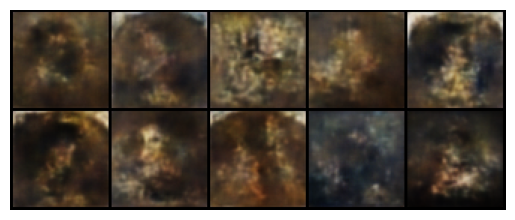

In [29]:
def generate_images(vae, num_images=10):
    vae.eval()
    
    with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(num_images, 128).to(device)
        
        # Decode them to generate images
        generated_images = vae.decode(z)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2
        
        # Create a grid of images
        img_grid = make_grid(generated_images.cpu(), nrow=5)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

# Generate and visualize 10 images
generate_images(vae, num_images=10)


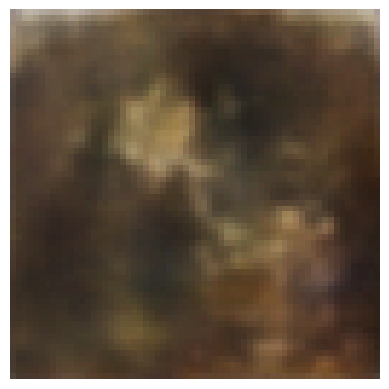

In [30]:
with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(1, 128).to(device)
        
        # Decode them to generate images
        generated_images = vae.decode(z)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2
        
        # Create a grid of images
        img_grid = make_grid(generated_images.cpu(), nrow=5)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

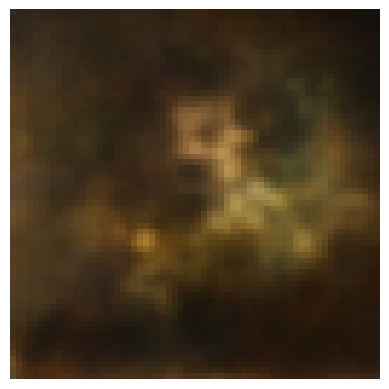

In [31]:
with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(1, 128).to(device)
        
        # Decode them to generate images
        generated_images = vae.decode(z)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2
        
        # Create a grid of images
        img_grid = make_grid(generated_images.cpu(), nrow=5)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

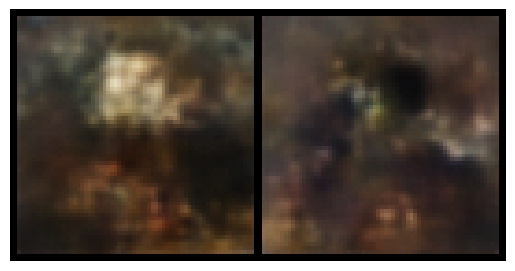

In [32]:
with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(2, 128).to(device)
        
        # Decode them to generate images
        generated_images = vae.decode(z)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2
        
        # Create a grid of images
        img_grid = make_grid(generated_images.cpu(), nrow=5)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

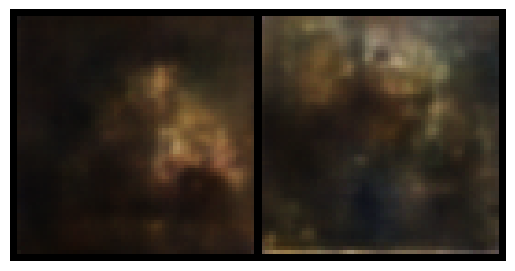

In [33]:
with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(2, 128).to(device)
        
        # Decode them to generate images
        generated_images = vae.decode(z)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2
        
        # Create a grid of images
        img_grid = make_grid(generated_images.cpu(), nrow=5)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

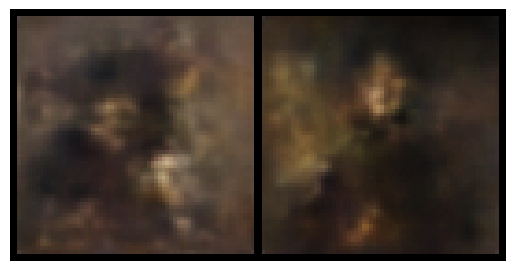

In [37]:
with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(2, 128).to(device)
        
        # Decode them to generate images
        generated_images = vae.decode(z)
        
        # Rescale images from [-1, 1] to [0, 1]
        generated_images = (generated_images + 1) / 2
        
        # Create a grid of images
        img_grid = make_grid(generated_images.cpu(), nrow=5)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()